# Excersise 8 Programming Task

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_swiss_roll

from scipy.spatial.distance import cdist

from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

## 2 (a)

In [2]:
data_full = make_swiss_roll(n_samples=800, random_state=1234)

In [3]:
data = data_full[0]

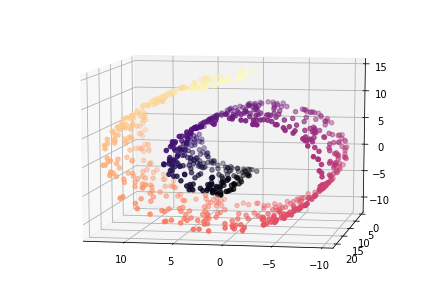

In [4]:
fig = pyplot.figure()
ax = Axes3D(fig)

ax.scatter(data[:, 0], data[:, 1], data[:, 2], c = data_full[1], cmap='magma') # using the 'right' colors
ax.view_init(10, 100)
pyplot.show()

## 2 (b)

In [5]:
X = data.T

In [6]:
C = np.cov(X)

In [7]:
eigenvalues, eigenvectors = np.linalg.eig(C)

In [8]:
v = eigenvectors[:2]

In [9]:
y = None
for item in X.T:
    if y is None:
        y = v.dot(item)
    else:
        y = np.vstack((y, v.dot(item)))

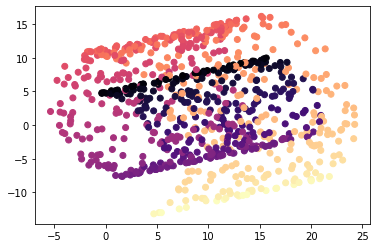

In [10]:
pyplot.scatter(y[:, 0], y[:, 1], c = data_full[1], cmap='magma')
pyplot.show() 

### What is going on here
We can see, that we did in fact reduce the dimensionality of the initial swiss roll data from 3D to 2D

However, the result even though it looks cool is not useful to us at all.

One can see based on the colors, that datapoints, which belong together are not seperated from other datapoints, because the data is not linearly seperable

There is pretty much nothing we can do with this data, no svm, no linear regression.

## 2 (c)

In [11]:
X = X.T

In [12]:
D = cdist(X, X)

In [13]:
def k_neigh(X, D, k):
    Xn = D
    for i in range(0, len(X)):
        idx = np.argpartition(D[i], k)
        Xn[i][idx[k:]] = float('infinity')
    return Xn

def e_neigh(X, D, e):
    Xn = D
    for i in range(0, len(X)):
        for j in range(0, len(X)):
            if Xn[i, j] > e:
                Xn[i, j] = float('infinity')
    return Xn

In [14]:
W = e_neigh(X, D, 4)

## 2 (d)

In general, it is discouraged to use high values for k nearest neighbor graph, because with too high values<br>
too many datapoints will be connected to each other.<br>
With a value too small however, we will not have a meaningful connection of datapoints.<br>
I've tried out a few values and based on observation it seems that following values are good:
* 10 for k nearest neighbor graph
* 4 for e graph

In [15]:
from numba import jit

@jit
def floyd(W):
    D = W
    n = len(W[0])
    for k in range(0, n):
        for i in range(0, n):
            for j in range(0, n):
                D[i, j] = min([D[i,j], D[i, k] + D[k, j]])
    return D

In [16]:
D_w = floyd(W)

In [17]:
def mds(A, d = 2):
    n = len(A)
    D = A**2
    G = D - D.mean(axis=0)
    G = G - G.mean(axis=1)
    G = -0.5*G
    
    G = (G+G.T)/2
    
    l, v = np.linalg.eig(G)
    
    pairs = sorted(zip(l,v.T), key=lambda x: x[0].real, reverse=True)
    
    l = [d[0] for d in pairs[0:d]]
    v = np.array([d[1] for d in pairs[0:d]])
    R = np.diag(np.sqrt(l))@v
    return R.T

## 2 (e)

In [18]:
X_rec = mds(D_w, 2)

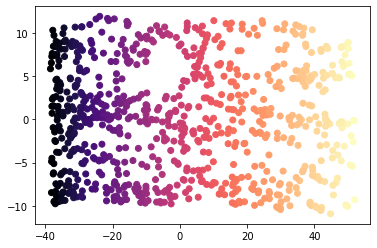

In [19]:
pyplot.scatter(X_rec.T[0], X_rec.T[1], c = data_full[1], cmap='magma')
pyplot.show()

### This is definetly an improvement compared to PCA.
#### unlike with PCA, data groups are not layered on top of each other, but seperated nicely.
